In [1]:
import pandas as pd 
import numpy as np

In [2]:
from datetime import datetime
import warnings
warnings.filterwarnings("ignore") 
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
#loading Excel file with multiple sheets
file_path = "Raw_data.xlsx"
xls = pd.ExcelFile(file_path)

In [6]:
#reading each sheets in the excel file
transactions = pd.read_excel(xls,'Transactions')
new_customers = pd.read_excel(xls,'NewCustomerList')
demographics = pd.read_excel(xls,'CustomerDemographic')
address = pd.read_excel(xls, 'CustomerAddress')

In [7]:
#creating a date column using existing DOB column
demographics['DOB'] = pd.to_datetime(demographics['DOB'])

# Step 2: Calculate age based on the current date
current_date = pd.to_datetime('now')
demographics['age'] = (current_date - demographics['DOB']).dt.days // 365  # Convert days to years

In [8]:
#merging datasets
df = demographics.merge(transactions, how = 'left', on='customer_id')
df= df.merge(address, how ='left', on='customer_id')

### Data Cleaning

In [9]:
#checking from duplicate values
df.duplicated().sum()

0

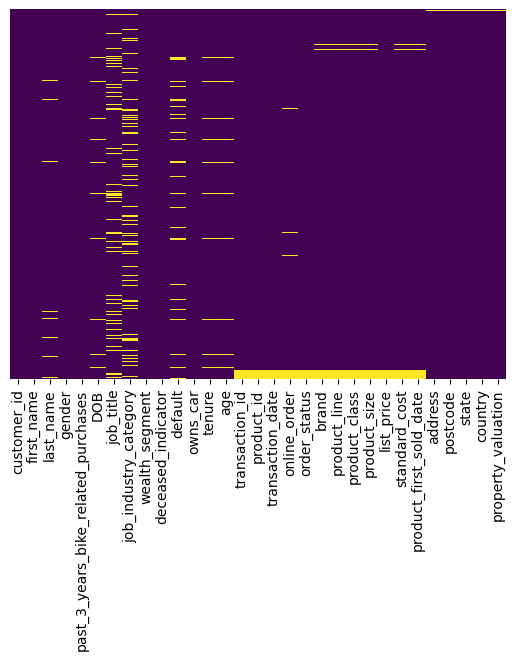

In [10]:
#using heatmap to check for missing values 
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

In [11]:
#checking for unique values
df.nunique()

customer_id                             4000
first_name                              3139
last_name                               3725
gender                                     6
past_3_years_bike_related_purchases      100
DOB                                     3448
job_title                                195
job_industry_category                      9
wealth_segment                             3
deceased_indicator                         2
default                                   90
owns_car                                   2
tenure                                    22
age                                       54
transaction_id                         19997
product_id                               101
transaction_date                         364
online_order                               2
order_status                               2
brand                                      6
product_line                               4
product_class                              3
product_si

In [12]:
#with the above unique count it shows the gender column has more than normal unique column(checking Gender Unique column)
df['gender'].unique()

array(['F', 'Male', 'Female', 'U', 'Femal', 'M'], dtype=object)

In [13]:
#using loc method to check names from F and M to male and female and U to unknoww
# Use loc to replace values
df.loc[df['gender'] == 'M', 'gender'] = 'Male'
df.loc[df['gender'] == 'F', 'gender'] = 'Female'
df.loc[df['gender'] == 'Femal', 'gender'] = 'Female'
df.loc[df['gender'] == 'U', 'gender'] = 'Unknown'

In [14]:
#using loc method to change state names from NSW to New South Wales and VIC to Victoria
df.loc[df['state'] =='NSW', 'state'] = 'New South Wales'
df.loc[df['state'] == 'VIC', 'state'] = 'Victoria'

In [15]:
#re-checking for gender unique values
df['gender'].unique()

array(['Female', 'Male', 'Unknown'], dtype=object)

In [16]:
#checking for null values 
df.isnull().sum()

customer_id                               0
first_name                                0
last_name                               655
gender                                    0
past_3_years_bike_related_purchases       0
DOB                                     457
job_title                              2477
job_industry_category                  3324
wealth_segment                            0
deceased_indicator                        0
default                                1499
owns_car                                  0
tenure                                  457
age                                     457
transaction_id                          507
product_id                              507
transaction_date                        507
online_order                            867
order_status                            507
brand                                   704
product_line                            704
product_class                           704
product_size                    

#### Handling missing values

In [17]:
#filling categorical columns with unknown, and numerical columns with the mean()
df.fillna({'job_title':'Unknown', 'job_industry_category':'Unknown'}, inplace = True)
df.fillna(df[['tenure','list_price','age','standard_cost','property_valuation']].mean(), inplace = True)

In [18]:
#dropping rows of columns that has no transactions history at all
df.dropna(subset=['transaction_date','online_order','order_status','brand','product_line','product_class','list_price',
                    'standard_cost','product_class'], inplace = True)

In [19]:
#filling the country column with the only country present(Australia), filling the state with the most occuring state(mode)
df.fillna({'country':'Australia'}, inplace=True)
df.fillna(df['state'].mode()[0], inplace = True)

In [20]:
#checking the information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19442 entries, 0 to 20003
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          19442 non-null  int64         
 1   first_name                           19442 non-null  object        
 2   last_name                            19442 non-null  object        
 3   gender                               19442 non-null  object        
 4   past_3_years_bike_related_purchases  19442 non-null  int64         
 5   DOB                                  19442 non-null  object        
 6   job_title                            19442 non-null  object        
 7   job_industry_category                19442 non-null  object        
 8   wealth_segment                       19442 non-null  object        
 9   deceased_indicator                   19442 non-null  object        
 10  default        

In [21]:
#checking the statistical values 
df.describe()

,customer_id,past_3_years_bike_related_purchases,tenure,age,transaction_id,product_id,transaction_date,online_order,list_price,standard_cost,product_first_sold_date,property_valuation
count,19442.000000,19442.000000,19442.000000,19442.000000,19442.000000,19442.000000,19442,19442.000000,19442.000000,19442.000000,19442.000000,19442.000000
mean,1738.958903,48.788653,10.680313,47.354064,9988.593355,45.804804,2017-07-01 16:38:56.055961344,0.500926,1107.429884,555.606674,38201.904794,7.518281
min,1.000000,0.000000,1.000000,23.000000,1.000000,0.000000,2017-01-01 00:00:00,0.000000,12.010000,7.210000,33259.000000,1.000000
25%,857.000000,24.000000,6.000000,38.000000,4975.250000,18.000000,2017-04-01 00:00:00,0.000000,575.270000,215.140000,35667.000000,6.000000
50%,1741.000000,48.000000,10.678256,47.390033,9984.500000,45.000000,2017-07-03 00:00:00,1.000000,1163.890000,507.580000,38216.000000,8.000000
75%,2615.000000,73.000000,15.000000,56.000000,14995.750000,72.000000,2017-10-02 00:00:00,1.000000,1635.300000,795.100000,40672.000000,10.000000
max,3500.000000,99.000000,22.000000,181.000000,20000.000000,100.000000,2017-12-30 00:00:00,1.000000,2091.470000,1759.850000,42710.000000,12.000000
std,1011.139208,28.586429,5.616284,12.771861,5779.658271,30.569061,NaN,0.500012,582.655811,405.618141,2877.921368,2.822306


In [22]:
#data inspection (first 5 rows)
df.head(5)

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,product_class,product_size,list_price,standard_cost,product_first_sold_date,address,postcode,state,country,property_valuation
0,1,Laraine,Medendorp,Female,93,1953-10-12 00:00:00,Executive Secretary,Health,Mass Customer,N,...,medium,medium,235.63,125.07,38482.0,060 Morning Avenue,2016.0,New South Wales,Australia,10.0
1,1,Laraine,Medendorp,Female,93,1953-10-12 00:00:00,Executive Secretary,Health,Mass Customer,N,...,medium,medium,1577.53,826.51,39526.0,060 Morning Avenue,2016.0,New South Wales,Australia,10.0
2,1,Laraine,Medendorp,Female,93,1953-10-12 00:00:00,Executive Secretary,Health,Mass Customer,N,...,low,small,1720.70,1531.42,37823.0,060 Morning Avenue,2016.0,New South Wales,Australia,10.0
3,1,Laraine,Medendorp,Female,93,1953-10-12 00:00:00,Executive Secretary,Health,Mass Customer,N,...,medium,medium,360.40,270.30,37873.0,060 Morning Avenue,2016.0,New South Wales,Australia,10.0
4,1,Laraine,Medendorp,Female,93,1953-10-12 00:00:00,Executive Secretary,Health,Mass Customer,N,...,medium,medium,71.49,53.62,38573.0,060 Morning Avenue,2016.0,New South Wales,Australia,10.0


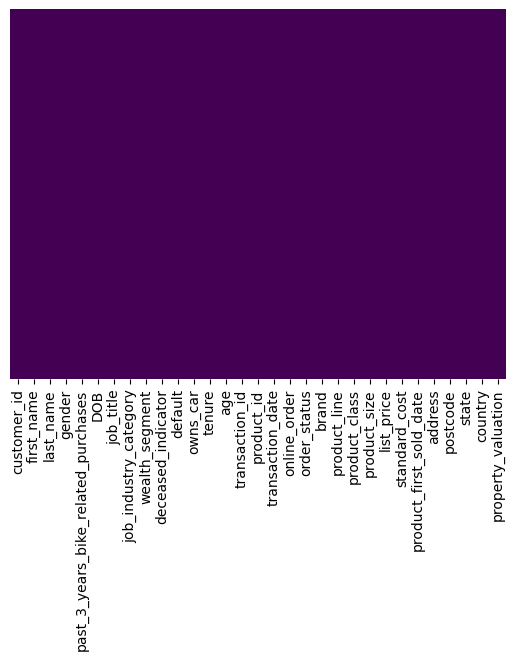

In [23]:
#rechecking for missing values using heatmap
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

### Data Preprocessing

In [24]:
# Feature engineering(extracting transaction month,year and day from the transaction date column)
df['transaction_month'] = df['transaction_date'].dt.month
df['transaction_year'] = df['transaction_date'].dt.year
df['transaction_day'] = df['transaction_date'].dt.day
df['transaction_day_of_week'] = df['transaction_date'].dt.dayofweek

In [25]:
# Convert dates to datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['product_first_sold_date'] = pd. to_datetime(df['product_first_sold_date'], unit='D', origin='1899-12-30')
# Calculate profit
df['profit'] = df['list_price'] - df['standard_cost']


In [26]:
#creating a new table from df existing table group by customerid
customer_data = df.groupby('customer_id').agg({
    'transaction_id':'count',
    'list_price': 'sum',
    'profit': 'sum',
    'transaction_date': ['max','min','nunique'],
    'online_order':'mean',
    'brand':lambda x: x.mode()[0], 
    'product_line':lambda x: x.mode()[0],
    'age': 'mean',
    'job_industry_category':lambda x: x.mode()[0],
    'state':lambda x: x.mode()[0]
}).reset_index()

In [27]:
#flatten multi-index columns
customer_data.columns = ['_'.join(col).strip('_')
                         for col in customer_data.columns.values]

In [28]:
# Renaming columns
customer_data = customer_data.rename(columns={
        'customer_id_': 'customer_id',
        'transaction_id_count': 'purchase_count',
        'list_price_sum': 'total_spend',
        'profit_sum': 'total_profit',
        'transaction_date_max': 'last_purchase',
        'transaction_date_min': 'first_purchase',
        'transaction_date_nunique': 'unique_purchase_days',
        'online_order_mean': 'online_purchase_ratio',
        'brand_<lambda>': 'preferred_brand',
        'product_line_<lambda>': 'preferred_product_line',
        'age_mean': 'age',
        'job_industry_category_<lambda>': 'job_industry_category',
        'state_<lambda>': 'state'
 })

In [30]:
#checking the new table
customer_data

,customer_id,purchase_count,total_spend,total_profit,last_purchase,first_purchase,unique_purchase_days,online_purchase_ratio,preferred_brand,preferred_product_line,age,job_industry_category,state
0,1,11,9084.45,3018.09,2017-12-23,2017-01-05,11,0.545455,Giant Bicycles,Standard,71.0,Health,New South Wales
1,2,3,4149.07,2226.26,2017-08-24,2017-05-04,3,0.333333,WeareA2B,Standard,44.0,Financial Services,New South Wales
2,3,7,9525.22,3290.21,2017-09-19,2017-02-23,7,0.142857,Trek Bicycles,Road,71.0,Property,New South Wales
3,4,2,1047.72,220.57,2017-06-18,2017-04-03,2,0.500000,Giant Bicycles,Standard,63.0,IT,QLD
4,5,6,5903.20,2394.94,2017-12-14,2017-03-03,6,0.333333,Norco Bicycles,Road,48.0,Unknown,New South Wales
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3486,3496,4,4725.38,2045.84,2017-04-18,2017-03-07,4,0.750000,Norco Bicycles,Standard,39.0,Manufacturing,New South Wales
3487,3497,3,3744.07,1648.32,2017-11-08,2017-09-01,3,0.666667,Giant Bicycles,Standard,39.0,Manufacturing,Victoria
3488,3498,6,5177.06,3147.33,2017-08-25,2017-02-03,6,0.833333,Solex,Standard,29.0,Manufacturing,Victoria
3489,3499,7,7673.48,4955.25,2017-11-09,2017-01-12,7,0.571429,Giant Bicycles,Standard,45.0,Manufacturing,QLD


In [31]:
#checking for null values in the customer_data table
customer_data.isnull().sum()

customer_id               0
purchase_count            0
total_spend               0
total_profit              0
last_purchase             0
first_purchase            0
unique_purchase_days      0
online_purchase_ratio     0
preferred_brand           0
preferred_product_line    0
age                       0
job_industry_category     0
state                     0
dtype: int64

In [33]:
# Calculate recency (days since last purchase)
customer_data['recency'] = (datetime.now() - customer_data['last_purchase']).dt.days
# Calculate customer tenure (days since first purchase)
customer_data['purchase_duration'] = (customer_data['last_purchase'] - customer_data['first_purchase']).dt.days
# Calculate average order value
customer_data['avg_order_value'] = customer_data['total_spend'] / customer_data['purchase_count']
# Calculate purchase frequency (purchases per day)
customer_data['purchase_frequency'] = customer_data['purchase_count'] / customer_data['purchase_duration'].replace(0,1)

### Exploratory Data Analysis

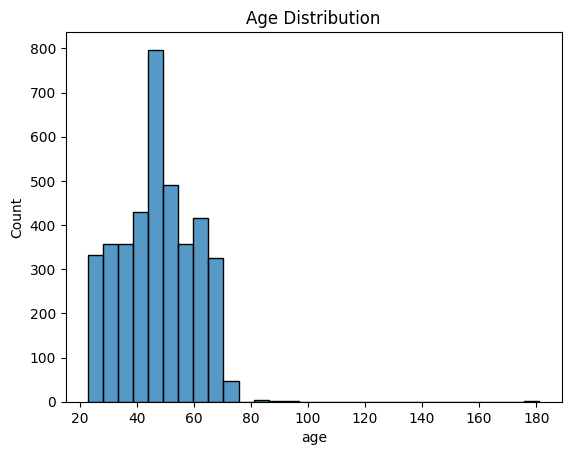

In [34]:
#Age distribution
sns.histplot(demographics['age'], bins=30)
plt.title('Age Distribution')
plt.show()

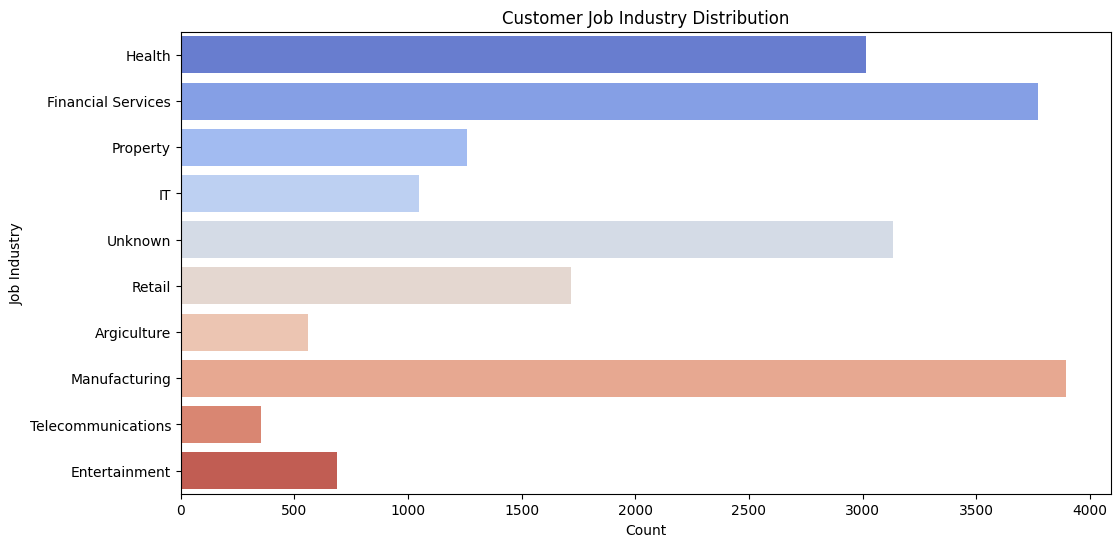

In [35]:
#job industry breakdown
plt.figure(figsize=(12,6))
sns.countplot(y=df['job_industry_category'], palette="coolwarm")
plt.xlabel("Count")
plt.ylabel("Job Industry")
plt.title("Customer Job Industry Distribution")
plt.show()

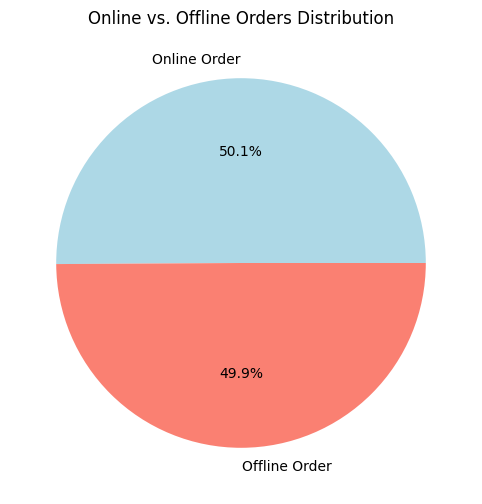

In [36]:
#Count values for online orders
order_counts = df['online_order'].value_counts()

# Create Pie Chart
plt.figure(figsize=(8,6))
plt.pie(order_counts, labels=['Online Order', 'Offline Order'], autopct='%1.1f%%', colors=['lightblue', 'salmon'])
plt.title("Online vs. Offline Orders Distribution")
plt.show()

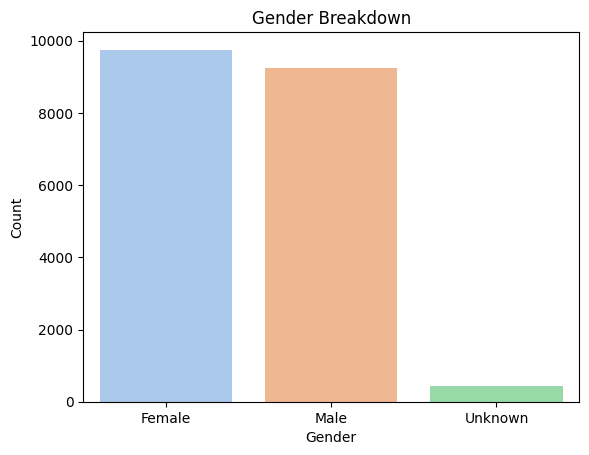

In [37]:
#gender distribution
sns.countplot(x=df['gender'], palette='pastel')
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Breakdown")
plt.show()

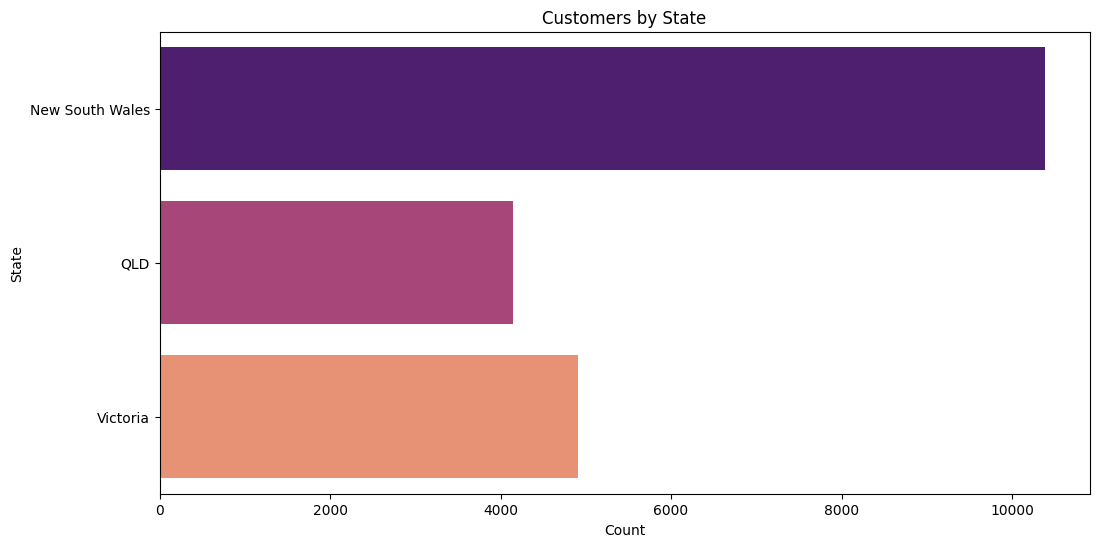

In [38]:
#distribution by state 
plt.figure(figsize=(12,6))
sns.countplot(y=df['state'], palette="magma")
plt.xlabel("Count")
plt.ylabel("State")
plt.title("Customers by State")
plt.show()

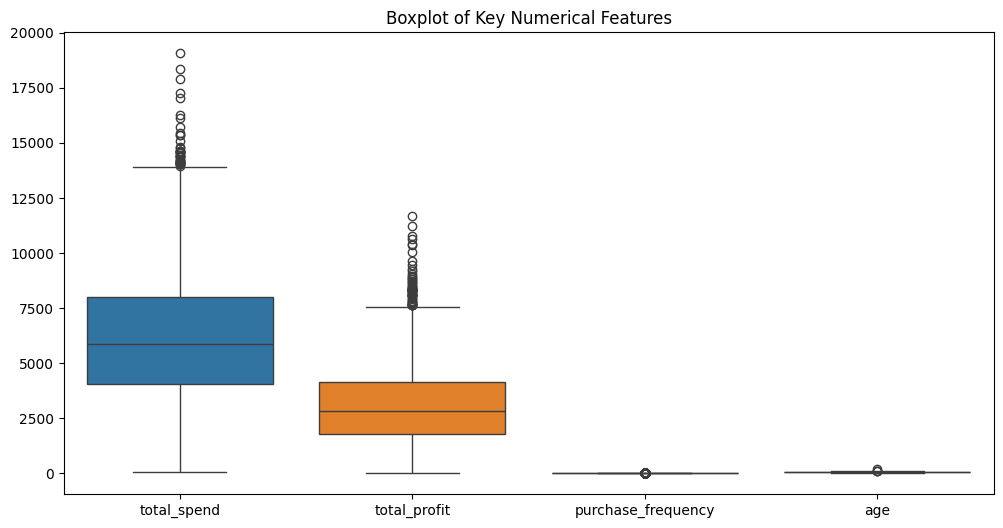

In [36]:
# Plot boxplots for numerical columns to check for outliers
plt.figure(figsize=(12,6))
sns.boxplot(data=customer_data[['total_spend', 'total_profit', 'purchase_frequency','age']])
plt.title('Boxplot of Key Numerical Features')
plt.show()

### Customer Segmentation Analysis

In [39]:
# Select features for clustering
clustering_features = customer_data[['recency', 'purchase_frequency', 'avg_order_value', 'total_spend','age','purchase_duration']]
clustering_features

,recency,purchase_frequency,avg_order_value,total_spend,age,purchase_duration
0,2718,0.031250,825.859091,9084.45,71.0,352
1,2839,0.026786,1383.023333,4149.07,44.0,112
2,2813,0.033654,1360.745714,9525.22,71.0,208
3,2906,0.026316,523.860000,1047.72,63.0,76
4,2727,0.020979,983.866667,5903.20,48.0,286
...,...,...,...,...,...,...
3486,2967,0.095238,1181.345000,4725.38,39.0,42
3487,2763,0.044118,1248.023333,3744.07,39.0,68
3488,2838,0.029557,862.843333,5177.06,29.0,203
3489,2762,0.023256,1096.211429,7673.48,45.0,301


In [40]:
#standardising our cluster features using RobustScaler because of outliers
X = clustering_features
scaler = RobustScaler()
scaled_features = scaler.fit_transform(X)

In [41]:
#Applying Principal Component Analysis (PCA)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

In [42]:
#assigning the scaled features to a dataframe
scaled_df = pd.DataFrame(scaled_features, columns=X.columns)

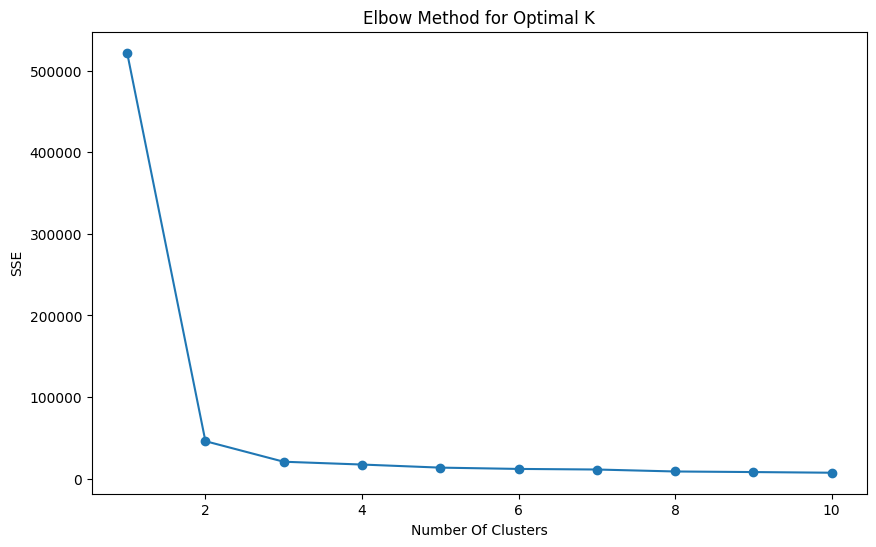

In [43]:
#using elbow method to pick the best k value
sse=[]
for k in range(1,11):
    kmeans = KMeans(n_clusters=k,random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1,11), sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number Of Clusters')
plt.ylabel('SSE')
plt.show()

In [44]:
#applying Kmeans model using 3 as the cluster value
kmeans = KMeans(n_clusters=3, random_state =42)
customer_data['cluster'] = kmeans.fit_predict(scaled_features)

In [45]:
#calculating the silhouette_score
from sklearn.metrics import silhouette_score
score = silhouette_score(scaled_features, customer_data['cluster'])
print(f"Silhouette Score: {score}")

Silhouette Score: 0.9656408135911452


In [46]:
#checking the performance of the Kmeans label using classfication and confusion_matrix
print(confusion_matrix(customer_data['cluster'],kmeans.labels_))
print(classification_report(customer_data['cluster'],kmeans.labels_))

[[3421    0    0]
 [   0   65    0]
 [   0    0    5]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3421
           1       1.00      1.00      1.00        65
           2       1.00      1.00      1.00         5

    accuracy                           1.00      3491
   macro avg       1.00      1.00      1.00      3491
weighted avg       1.00      1.00      1.00      3491



In [47]:
#classifying the clusters based on mean for numerical columns and mode for categorical columns
cluster_summary = customer_data.groupby('cluster').agg({
    'recency': 'mean',
    'purchase_frequency': 'mean',
    'avg_order_value': 'mean',
    'total_spend':'mean',
    'age':'mean',
    'purchase_duration':'mean'
})
cluster_summary

,recency,purchase_frequency,avg_order_value,total_spend,age,purchase_duration
cluster,,,,,,
0,2771.392575,0.026109,1107.391907,6268.592759,47.311793,242.206957
1,2876.723077,0.989744,1062.965692,1124.060154,47.984615,0.153846
2,2866.400000,1.900000,1134.769000,2546.412000,44.400000,1.200000


In [48]:
#Assign Labels Based on Insights
cluster_labels = {
    0: "High-Spending Loyal Customers",
    1: "New Low-Spending Buyers",
    2: "Frequent Moderate-Spenders"
}

# Map labels to clusters
customer_data['cluster_label'] = customer_data['cluster'].map(cluster_labels)

customer_data[['cluster', 'cluster_label']].head()

,cluster,cluster_label
0,0,High-Spending Loyal Customers
1,0,High-Spending Loyal Customers
2,0,High-Spending Loyal Customers
3,0,High-Spending Loyal Customers
4,0,High-Spending Loyal Customers


In [50]:
#Merge the Cluster Labels into the Full Dataset
df_final = df.merge(
    customer_data[['customer_id', 'recency', 'purchase_frequency', 'avg_order_value', 'total_spend', 'purchase_duration', 'cluster_label']], 
    on='customer_id', 
    how='left'
)
df_final

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,transaction_year,transaction_day,transaction_day_of_week,profit,recency,purchase_frequency,avg_order_value,total_spend,purchase_duration,cluster_label
0,1,Laraine,Medendorp,Female,93,1953-10-12 00:00:00,Executive Secretary,Health,Mass Customer,N,...,2017,23,5,110.56,2718,0.031250,825.859091,9084.45,352,High-Spending Loyal Customers
1,1,Laraine,Medendorp,Female,93,1953-10-12 00:00:00,Executive Secretary,Health,Mass Customer,N,...,2017,6,3,751.02,2718,0.031250,825.859091,9084.45,352,High-Spending Loyal Customers
2,1,Laraine,Medendorp,Female,93,1953-10-12 00:00:00,Executive Secretary,Health,Mass Customer,N,...,2017,11,3,189.28,2718,0.031250,825.859091,9084.45,352,High-Spending Loyal Customers
3,1,Laraine,Medendorp,Female,93,1953-10-12 00:00:00,Executive Secretary,Health,Mass Customer,N,...,2017,5,3,90.10,2718,0.031250,825.859091,9084.45,352,High-Spending Loyal Customers
4,1,Laraine,Medendorp,Female,93,1953-10-12 00:00:00,Executive Secretary,Health,Mass Customer,N,...,2017,21,1,17.87,2718,0.031250,825.859091,9084.45,352,High-Spending Loyal Customers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19437,3500,Josy,Fleeman,Female,71,1967-07-21 00:00:00,Unknown,Entertainment,Affluent Customer,N,...,2017,9,0,198.22,2855,0.028436,820.401667,4922.41,211,High-Spending Loyal Customers
19438,3500,Josy,Fleeman,Female,71,1967-07-21 00:00:00,Unknown,Entertainment,Affluent Customer,N,...,2017,16,3,827.16,2855,0.028436,820.401667,4922.41,211,High-Spending Loyal Customers
19439,3500,Josy,Fleeman,Female,71,1967-07-21 00:00:00,Unknown,Entertainment,Affluent Customer,N,...,2017,8,1,144.26,2855,0.028436,820.401667,4922.41,211,High-Spending Loyal Customers
19440,3500,Josy,Fleeman,Female,71,1967-07-21 00:00:00,Unknown,Entertainment,Affluent Customer,N,...,2017,11,2,15.08,2855,0.028436,820.401667,4922.41,211,High-Spending Loyal Customers


### EDA on Segmented Data

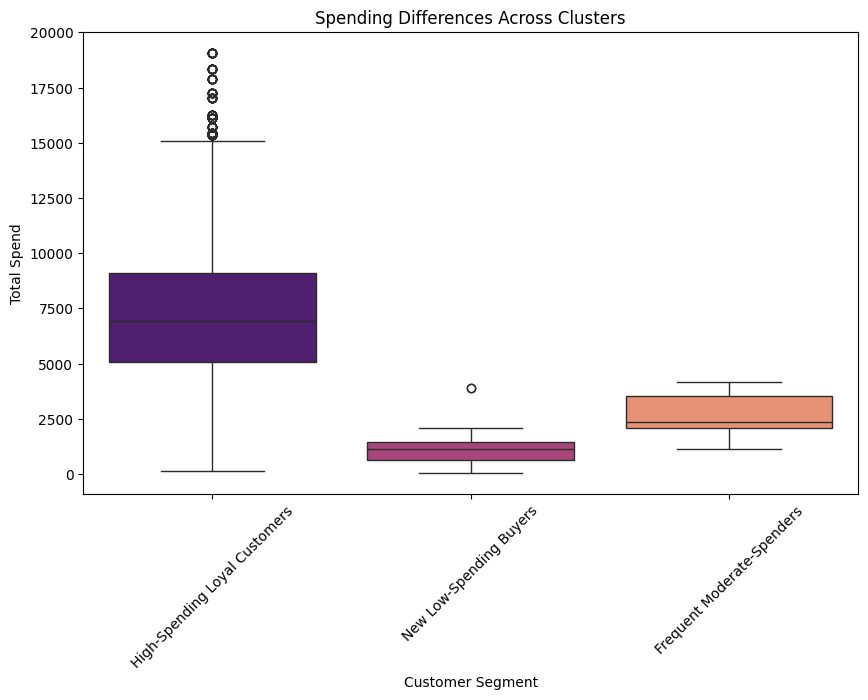

In [51]:
#spending habit across clusers
plt.figure(figsize=(10,6))
sns.boxplot(x=df_final['cluster_label'], y=df_final['total_spend'], palette='magma')
plt.xlabel("Customer Segment")
plt.ylabel("Total Spend")
plt.title("Spending Differences Across Clusters")
plt.xticks(rotation=45)
plt.show()